In [19]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

import os

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [3]:
ACTUAL_PATH = os.path.abspath(".")
DATA_PATH = os.path.join(ACTUAL_PATH, "analise_descritiva")

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "empresas_go.csv"), delimiter="|", encoding="utf-8")

cnaes = ('35', '19', '05', '06', '26', '27')

df = df.apply(lambda x: x.astype(str).str.upper().replace([r'^\s*$','NONE','NAN'], None, regex=True) if x.dtype == 'object' or x.dtype == 'string' else x)

df['cnaes_secundarios'] = df['cnaes_secundarios'].replace("{}", None)
df['cnaes_secundarios'] = df['cnaes_secundarios'].str.split("\", \"").replace(r'\{|\}|\"', '', regex=True)

df = df.explode('cnaes_secundarios')

df['cod_cnaes_secundarios'] = df['cnaes_secundarios'].str.extract('^(\d+)')
df['desc_cnaes_secundarios'] = df['cnaes_secundarios'].str.split(':', n=1, expand=True)[1]

mask = df['cod_cnaes_secundarios'].isna()

df['cod_cnaes_secundarios'] = df['cod_cnaes_secundarios'].str[-7:].str.zfill(7)

df = df.loc[~mask]

df['cnae_fiscal'] = df['cnae_fiscal'].astype('str')

df = (df.loc[df['cod_cnaes_secundarios'].str.startswith(cnaes) | df['cnae_fiscal'].str.startswith(cnaes)])

C:\Users\Vaug\AppData\Local\Temp\ipykernel_8276\3646848437.py:1: DtypeWarning: Columns (41,42,43,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_PATH, "empresas_go.csv"), delimiter="|", encoding="utf-8")


In [5]:

df.drop(['cnaes_secundarios', 'nome_cidade_no_exterior', 'codigo_porte', 'codigo_natureza_juridica', 'identificador_matriz_filial', 'situacao_cadastral', 'motivo_situacao_cadastral', 'codigo_pais', 'pais', 'uf', 'codigo_municipio', 'codigo_municipio_ibge'], axis=1, inplace=True)
del mask
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1175 entries, 248 to 395019
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   cnpj_basico                          1175 non-null   int64  
 1   porte                                1175 non-null   object 
 2   razao_social                         1174 non-null   object 
 3   natureza_juridica                    1175 non-null   object 
 4   qualificacao_do_responsavel          1175 non-null   int64  
 5   capital_social                       1175 non-null   float64
 6   ente_federativo_responsavel          0 non-null      object 
 7   opcao_pelo_simples                   1175 non-null   bool   
 8   data_opcao_pelo_simples              584 non-null    object 
 9   data_exclusao_do_simples             313 non-null    object 
 10  opcao_pelo_mei                       1175 non-null   bool   
 11  data_opcao_pelo_mei       

In [6]:
print(df['cnpj'].nunique())

452


In [7]:

df.to_csv(os.path.join(DATA_PATH, "empresas_go_cnae_35.csv"), sep="|", encoding="utf-8", index=False)

### Exercício 2
Como o CNAE para eficiência energética são aqueles com iniciais 35, 19, 05, 06, 26 ou 27, vamos filtrar as empresas que possuem esse CNAE

Foram obtidas 449 empresas relacionadas que possuem eficiencia energética como CNAE secundário.

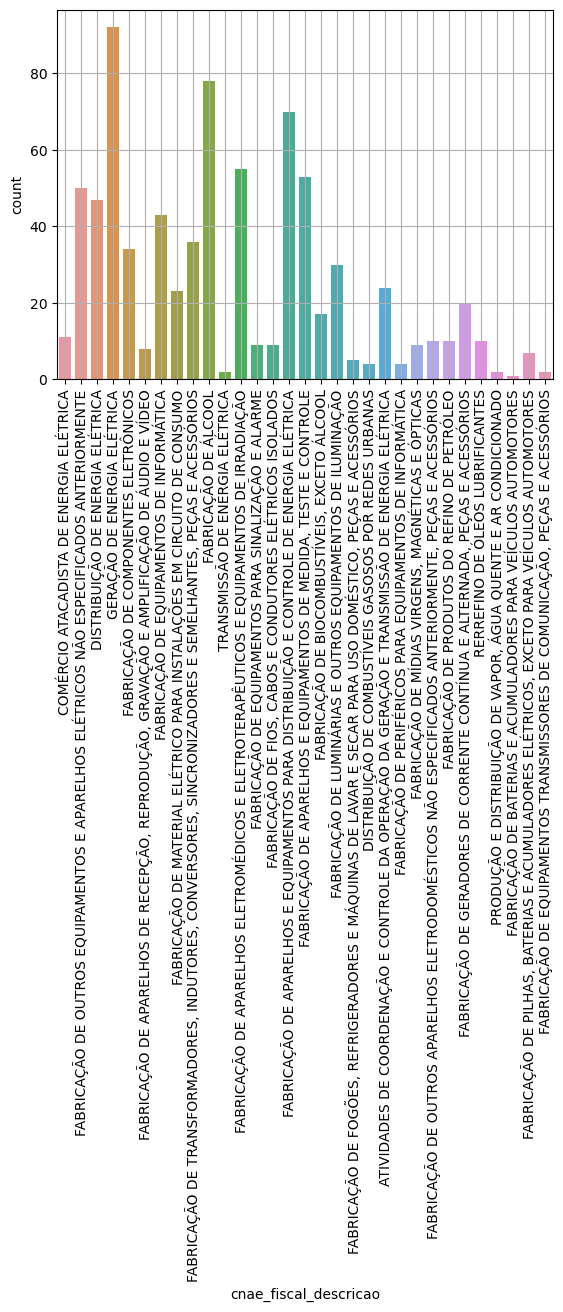

In [8]:
sns.countplot(x='cnae_fiscal_descricao', data=df.loc[df['cnae_fiscal'].str.startswith(cnaes)], orient="h")
plt.xticks(rotation=90)
plt.grid()

In [9]:
print(len(df.loc[df['cnae_fiscal'].str.startswith(cnaes)]))

775


### Exercício 3

Foram encontrados 775 itens relacionados à eficiência energética, estes que foram encontrados através da filtragem do código do CNAE Fiscal e apresentados com a descrição.

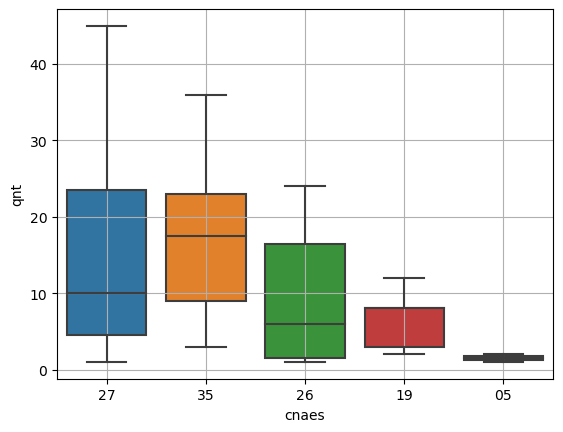

In [10]:
temp = pd.DataFrame()

temp['qnt'] = df.loc[df['cod_cnaes_secundarios'].str.startswith(cnaes)].value_counts('cod_cnaes_secundarios')

for it in cnaes:
	temp.loc[temp.index.str.startswith(it), 'cnaes'] = it
sns.boxplot(data=temp, x='cnaes', y='qnt', orient="v")
plt.grid()

del temp

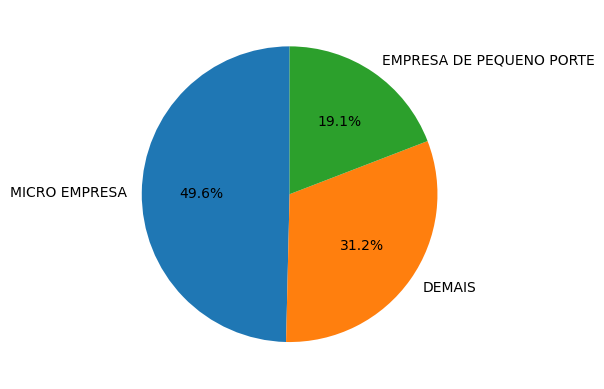

In [11]:
temp = pd.DataFrame()
temp['qnt'] = df['porte'].value_counts()

plt.pie(temp['qnt'], labels=temp.index, autopct='%1.1f%%', startangle=90)

del temp

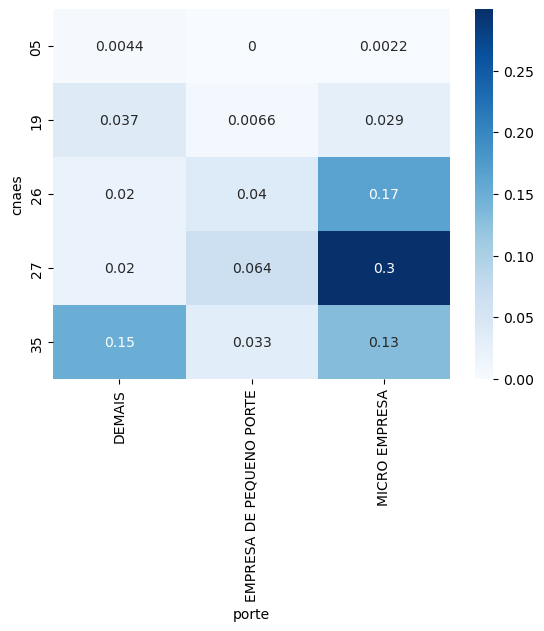

In [12]:
temp = df

for it in cnaes:
	temp.loc[temp['cod_cnaes_secundarios'].str.startswith(it), 'cnaes'] = it

counts = temp[['cnaes', 'porte']].groupby(['cnaes', 'porte']).size().reset_index()
counts_sum = counts[0].sum()

counts['normalized'] = counts[0].apply(lambda x: x / counts_sum)

counts = counts.pivot(index='cnaes', columns='porte', values='normalized').fillna(0)

sns.heatmap(counts, annot=True, cmap='Blues')

del temp, counts, counts_sum

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Vaug\AppData\Local\Temp\ipykernel_8276\4065477792.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  temp['nome_fantasia_processed'] = temp['nome_fantasia'].str.replace('[^\w\s,\"\']','')
C:\Users\Vaug\AppData\Local\Temp\ipykernel_8276\4065477792.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nome_fantasia_processed'] = temp['nome_fantasia'].str.replace('[^\w\s,\"\']','')
C:\Users\Vaug\AppData\Local\Temp\ipykernel_8276\4065477792.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

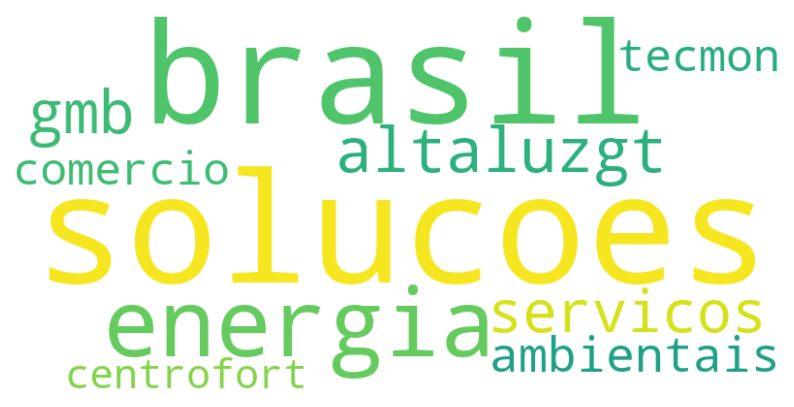

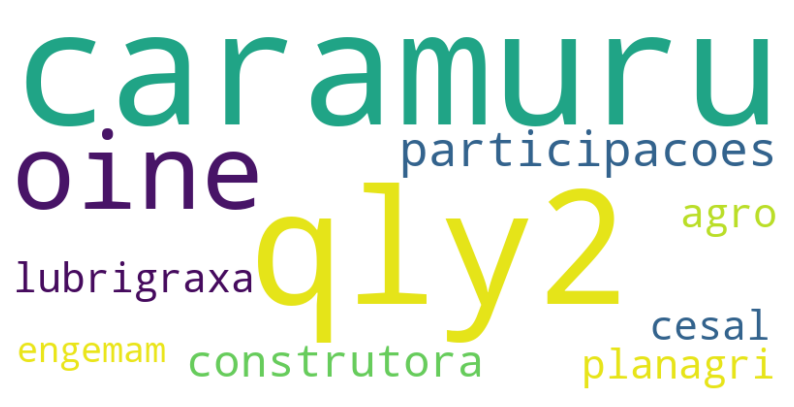

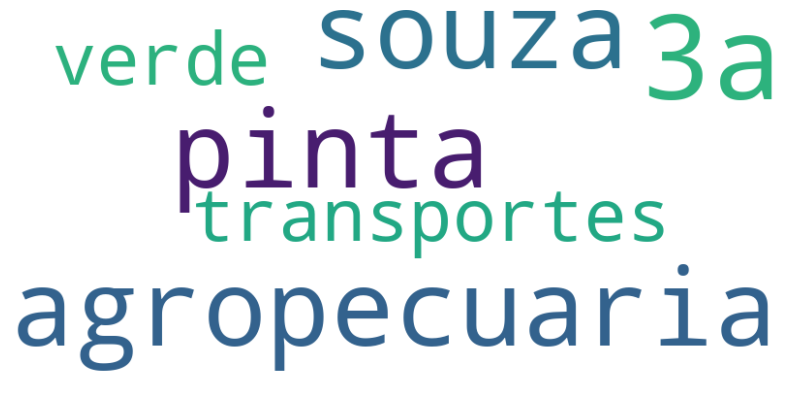

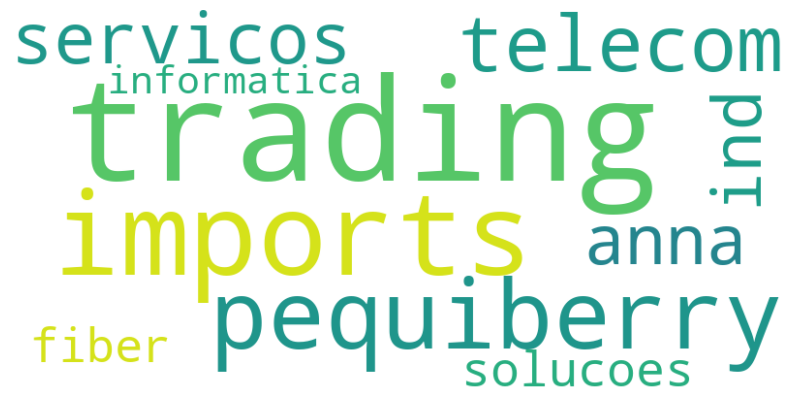

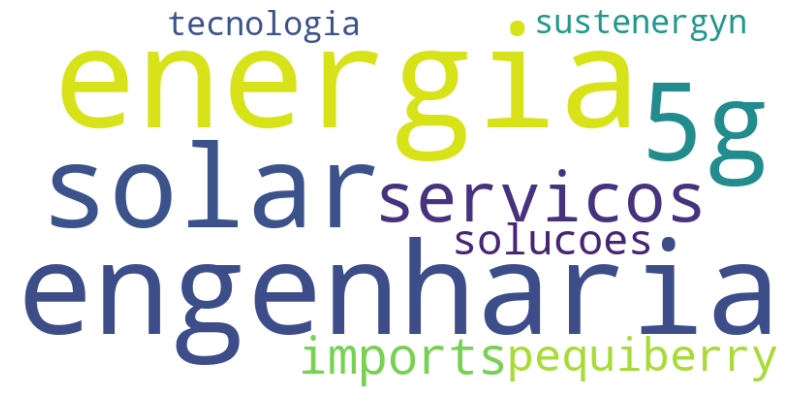

In [35]:
nltk.download('stopwords')


stop_words_pt = nltk.corpus.stopwords.words('portuguese')
lemmatizer = nltk.WordNetLemmatizer()

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_pt)

for it in cnaes:
	temp = df.loc[df['cod_cnaes_secundarios'].str.startswith(it) & df['nome_fantasia'].notna()]

	temp['nome_fantasia_processed'] = temp['nome_fantasia'].str.replace('[^\w\s,\"\']','')
	temp['nome_fantasia_processed'] = temp['nome_fantasia_processed'].str.strip()
	try:
		tfidf = tfidf_vectorizer.fit_transform(temp['nome_fantasia_processed'])
	except:
		continue

	tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

	wc = WordCloud(width=800, height=400, max_words=10, background_color='white')
	wc.generate_from_frequencies(tfidf_df.T.sum(axis=1))

	plt.figure(figsize=(10,6))
	plt.imshow(wc, interpolation='bilinear')
	plt.axis('off')